# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).


In [1]:
%matplotlib notebook
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import sqlite3
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
from mpl_toolkits import mplot3d
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report, confusion_matrix 
import seaborn as sns
import pydotplus
import graphviz
from sklearn import tree
from IPython.display import Image, display
from graphviz import Source

D:\conda\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
con = sqlite3.connect('data.sqlite') 
df = pd.read_sql_query(""" SELECT * FROM Reviews""", con) 
text=df['CleanedText']
label=df['Score']
x,x_test,y,y_test=train_test_split(text,label,test_size=0.2,random_state=0, stratify=label)
x_train,x_cv,y_train,y_cv=train_test_split(x,y,test_size=0.25, random_state=0, stratify=y)
x_train.shape


(61824,)

### BOW and TFIDF Vectorizers

In [152]:
#BOW
vect=CountVectorizer(min_df=15).fit(x_train)
train_cnt=vect.transform(x_train)
cv_cnt=vect.transform(x_cv)
test_cnt=vect.transform(x_test)
#TFIDF
idf=TfidfVectorizer(min_df=15).fit(x_train)
train_tf=idf.transform(x_train)
test_tf=idf.transform(x_test)
cv_tf=idf.transform(x_cv)
cv_cnt.shape

(20608, 7800)

### AVG W2V Vectorizer

In [81]:
list_of_words=[]
for x in x_train.values:
    list_of_words.append(x.split())
    
w2v_model=Word2Vec(list_of_words, min_count=5, size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

    
test_word_list=[]
for x in x_test.values:
    test_word_list.append(x.split())
    
cv_word_list=[]
for x in x_cv.values:
    cv_word_list.append(x.split())
    
train_w2v=[];
for x in tqdm(list_of_words):
    sent_vec=np.zeros(50)
    cnt_words=0
    for y in x:
        if y in w2v_words:
            vec=w2v_model.wv[y]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_w2v.append(sent_vec)
    
    
cv_w2v=[];
for x in tqdm(cv_word_list):
    sent_vec=np.zeros(50)
    cnt_words=0
    for y in x:
        if y in w2v_words:
            vec=w2v_model.wv[y]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words != 0:
        sent_vec /= cnt_words
    cv_w2v.append(sent_vec)

test_w2v=[]
for x in tqdm(test_word_list):
    sent_vec=np.zeros(50)
    cnt_words=0
    for y in x:
        if y in w2v_words:
            vec=w2v_model.wv[y]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_w2v.append(sent_vec)
    

100%|███████████████████████████████████| 20608/20608 [00:42<00:00, 483.21it/s]


### TFIDF AVG W2V Vectorizer

In [118]:
model = TfidfVectorizer()
model.fit_transform(x_train.values)

dicti= dict(zip(model.get_feature_names(), list(model.idf_)))

tfidf_feat = model.get_feature_names() 

train_df= [];
row=0;
for sent in tqdm(list_of_words): 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            
    
            tf_idf = dicti[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_df.append(sent_vec)
    row += 1
    
tfidf_feat = model.get_feature_names() 

test_df= []; 
row=0;
for sent in tqdm(test_word_list):
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]

            tf_idf = dicti[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_df.append(sent_vec)
    row += 1
    
    
cv_df= []; 
row=0;
for sent in tqdm(cv_word_list):
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]

            tf_idf = dicti[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    cv_df.append(sent_vec)
    row += 1

100%|████████████████████████████████████| 20608/20608 [11:48<00:00, 29.10it/s]


### Function to find optimal depth and optimal min_samples_split

In [7]:
def hypertuning(train,cv,y_train,y_cv):
    roc_scores_cv=[]
    roc_scores_train=[]
    final_train=[]
    final_cv=[]
    depth_list=[1,5,1000]
    samples_list=[5,700]
    for i in samples_list:
        for x in depth_list:
            clf=DecisionTreeClassifier(max_depth=x, min_samples_split=i, class_weight='balanced',random_state=42)
            clf.fit(train,y_train)
            prob_cv=clf.predict_proba(cv)[:,1]
            prob_train=clf.predict_proba(train)[:,1]
            roc_cv=roc_auc_score(y_cv,prob_cv)
            roc_train=roc_auc_score(y_train,prob_train)
            roc_scores_cv.append(roc_cv)
            roc_scores_train.append(roc_train)
        final_train.append(roc_scores_train)
        roc_scores_train=[]
        final_cv.append(roc_scores_cv)
        roc_scores_cv=[]
    z_train=np.array(final_train)
    z_cv=np.array(final_cv)
    A,B=np.meshgrid(depth_list,samples_list)
    fig=plt.figure()
    ax1=fig.add_subplot(121,projection='3d')
    ax2=fig.add_subplot(122,projection='3d')
    #ax1.set_title('Training Dataset')
    ax1.plot_surface(A, B, z_train,label='training')
    ax1.set_xlabel("depth")
    ax1.set_ylabel("samples_split")
    ax1.set_zlabel('AUC Score')
    ax1.set_title('Training Dataset')
    ax2.plot_surface(A, B, z_cv,label='cv')
    ax2.set_title('CV Dataset')
    ax2.set_xlabel("depth")
    ax2.set_ylabel("samples_split")
    ax2.set_zlabel('AUC Score')
    plt.show()

### Function to plot ROC curves

In [8]:
def rocPlot(train_data,test_data, y_train, y_test):
    pred_proba = clf.predict_proba(test_data)[:,1]
    fpr,tpr, thresholds=roc_curve(y_test, pred_proba)
    roc_auc=roc_auc_score(y_test, pred_proba)
    plt.plot(fpr, tpr, label='AUC= %0.3f for test set' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    pred_probat = clf.predict_proba(train_data)[:,1]
    fpr,tpr, thresholds=roc_curve(y_train, pred_probat)
    roc_auc=roc_auc_score(y_train, pred_probat)
    plt.plot(fpr, tpr, label='AUC= %0.3f for training set' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curves of train and test data')
    plt.legend(loc="lower right")
    plt.show()

### Function to plot confusion matrix

In [9]:
def con_mx(target1, predict1, target2, predict2):
    cm = confusion_matrix(target1, predict1)
    cm2=confusion_matrix(target2, predict2)
    cm = pd.DataFrame(cm)
    cm2 = pd.DataFrame(cm2)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    cm2.index.name = 'Actual'
    cm2.columns.name = 'Predicted'
    fig, (ax1,ax2)= plt.subplots(1,2)
    ax1.set_title('Training Dataset')
    ax2.set_title('Test Dataset')
    sns.heatmap(cm, annot=True, fmt='d', ax=ax1)
    sns.heatmap(cm2, annot=True, fmt='d', ax=ax2)


# Applying Decision Trees

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

### Hyperparameter tuning to find optimal depth and min samples split

<IPython.core.display.Javascript object>


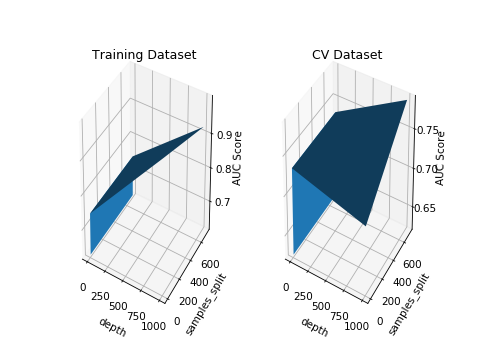

In [154]:
hypertuning(train_cnt,cv_cnt, y_train,y_cv)

Decision tree has two hyperparameter, depth and minimum_samples_split, to tune. As more depth and less samples splitting threshold lead to overfitting and DT are very prone to overfitting. On other side, less depth and heavy sample split threshold lead to undefitting and high bias.

So, in this 3D plot i've tried to find optimal depth, min_samples_split based on AUC score for both training and cv dataset.

### Fitting decision tree with optimal hyperparameter

In [155]:
clf=DecisionTreeClassifier(max_depth=80, min_samples_split=500, class_weight='balanced',random_state=42)
clf.fit(train_cnt,y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=80, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

### ROC plot for training and test dataset

<IPython.core.display.Javascript object>


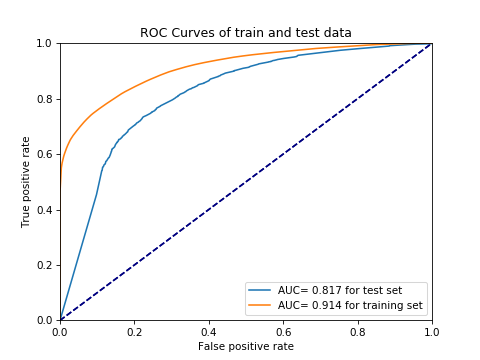

In [156]:
rocPlot(train_cnt,test_cnt,y_train,y_test)

### Confusion matrix plot training and test dataset

<IPython.core.display.Javascript object>


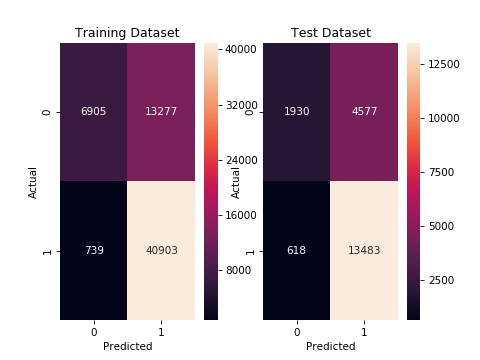

In [157]:
pred=clf.predict(test_cnt)
pred_train=clf.predict(train_cnt)
con_mx(pred_train, y_train,pred,y_test)

### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [159]:
coef_l2=clf.feature_importances_
features_20=np.argpartition(coef_l2,-20)[-20:] #only to sort incides of top 20 weights
for i in features_20:
    print(vect.get_feature_names()[i], end=', ')

awful, find, highly, tasty, would, best, delicious, money, wonderful, disappointed, nice, love, not, good, excellent, bad, perfect, great, loves, favorite, 

Important features are retrived using method feature_importances_. It is computed as total reduction of the criterion brought by that feature, known as gini importance i.e., decrease in gini impurity for a given variable.

### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

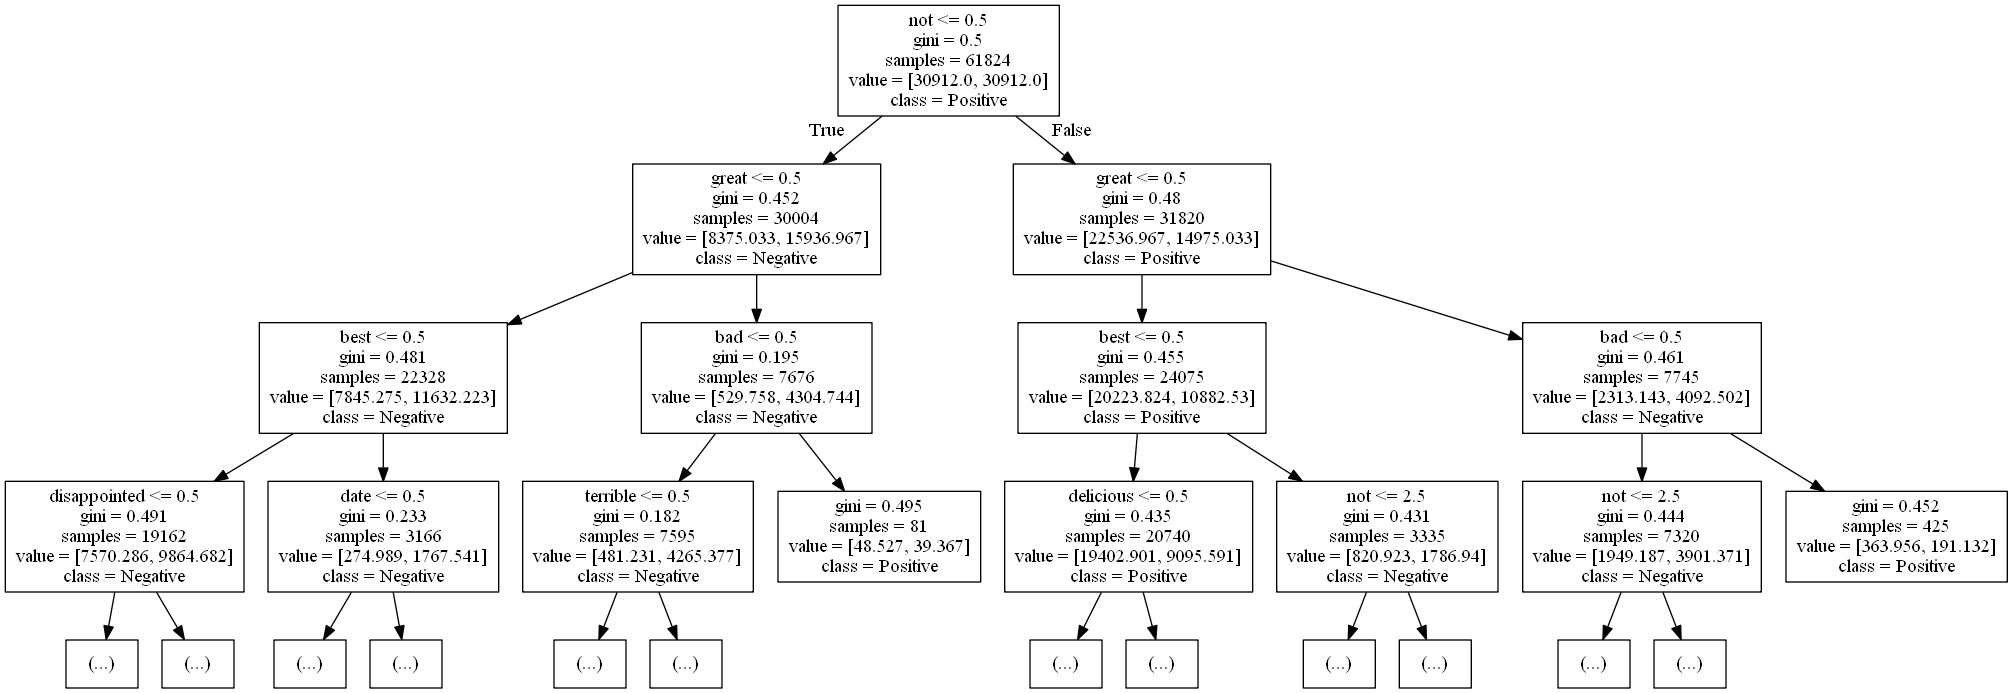

In [160]:
target=['Positive', 'Negative']
data=tree.export_graphviz(clf,max_depth=3, feature_names=vect.get_feature_names(),class_names=target) #Create DOT file
plot=pydotplus.graph_from_dot_data(data) #Create Plot
Image(plot.create_png()) #Show Plot

Above is the graphical visualization of the learned DT from given training data.

Here, in not<=0.5, 0.5 is the value around which input space is segmented and thus, inputs are classified around it. For continous feature the calcualtion of value is specific to different algorithm as they may consider the feature values itself or sampling along a dimension.

Next is gini impurity, which measures the liklihood of incorrect classification. For ex, gini of 0.217 means, there is 21.7% probability that classification by this attribute may be wrong.

So, while training, gini impurity was calculated for each feature and for each feature, the value was chosen for which decision surface gave maximum correct classification, hence, less gini impurity. For next node, same procedure followed.


## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

### Hyperparameter tuning to find optimal depth and min samples split

<IPython.core.display.Javascript object>


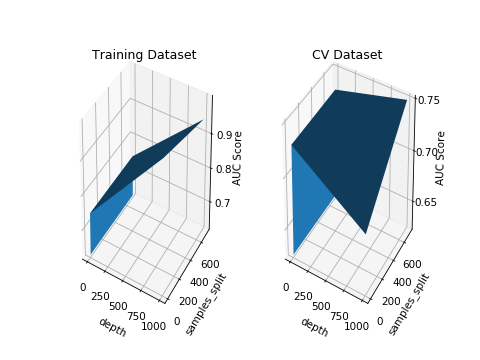

In [163]:
hypertuning(train_tf,cv_tf, y_train,y_cv)

### Hyperparameter tuning to find optimal depth and min samples split

In [166]:
clf=DecisionTreeClassifier(max_depth=50, min_samples_split=520, class_weight='balanced',random_state=42)
clf.fit(train_tf,y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=50, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=520,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

### ROC plot for training and test dataset

<IPython.core.display.Javascript object>


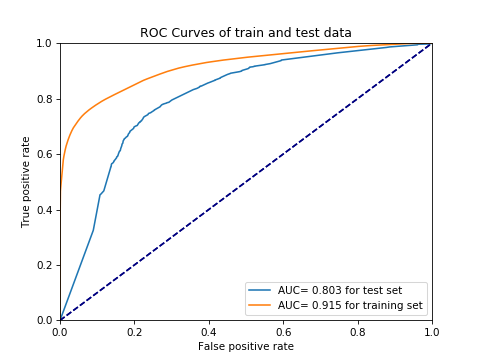

In [165]:
rocPlot(train_tf,test_tf,y_train,y_test)

### Confusion matrix plot training and test dataset

<IPython.core.display.Javascript object>


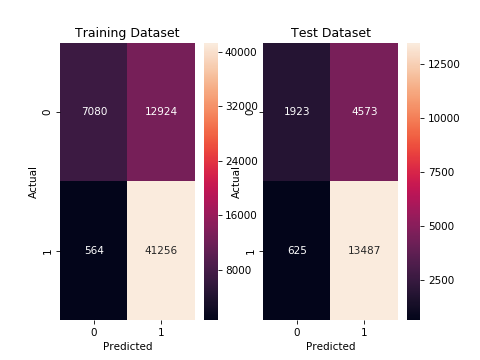

In [79]:
pred=clf.predict(test_tf)
pred_train=clf.predict(train_tf)
con_mx(pred_train, y_train,pred,y_test)

### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

In [169]:
coef_l2=clf.feature_importances_
features_20=np.argpartition(coef_l2,-20)[-20:] #only to sort incides of top 20 weights
for i in features_20:
    print(idf.get_feature_names()[i], end=', ')

worst, terrible, money, tasty, favorite, good, disappointed, best, nice, not, highly, great, delicious, bad, wonderful, love, would, perfect, loves, excellent, 

The feature importances. The higher, the more important the feature. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.


### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

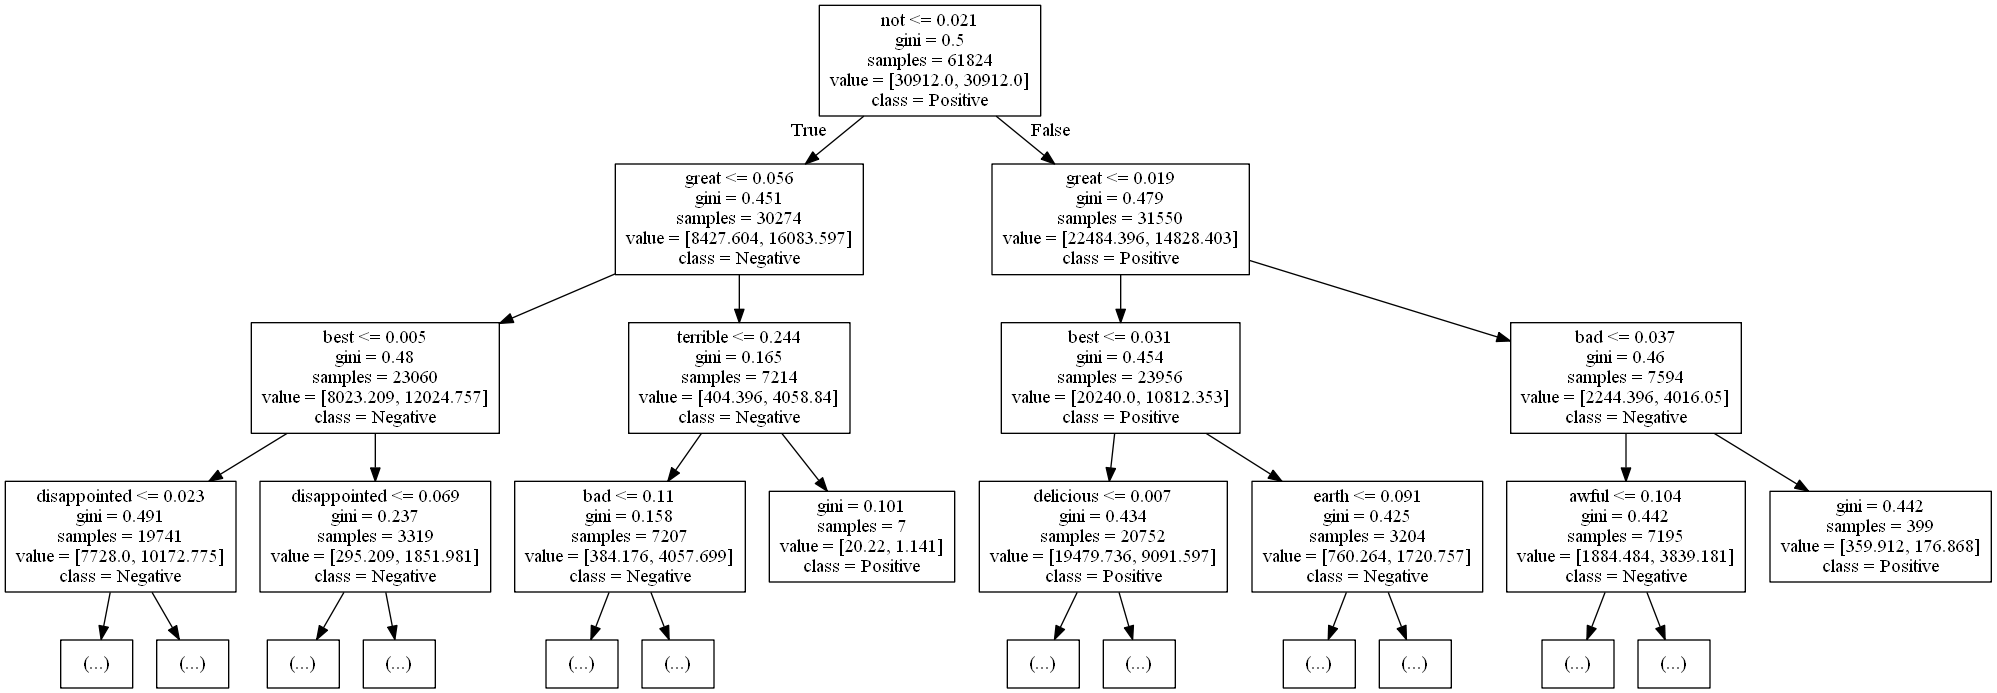

In [170]:
target=['Positive', 'Negative']
data=tree.export_graphviz(clf,max_depth=3, feature_names=idf.get_feature_names(),class_names=target) #Create DOT file
plot=pydotplus.graph_from_dot_data(data) #Create Plot
Image(plot.create_png()) #Show Plot

## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

### Hyperparameter tuning to find optimal depth and min samples split

<IPython.core.display.Javascript object>


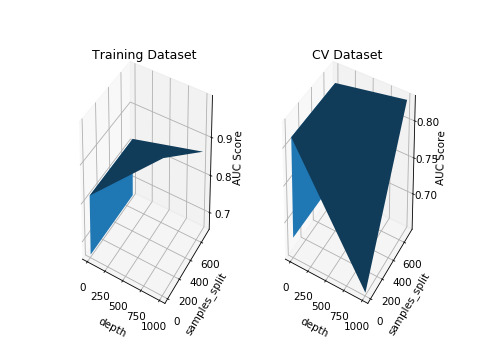

In [185]:
hypertuning(train_w2v,cv_w2v,y_train,y_cv)

### Hyperparameter tuning to find optimal depth and min samples split

In [171]:
clf=DecisionTreeClassifier(max_depth=90, min_samples_split=300, class_weight='balanced',random_state=42)
clf.fit(train_w2v,y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=90, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=300,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

### ROC plot for training and test dataset

<IPython.core.display.Javascript object>


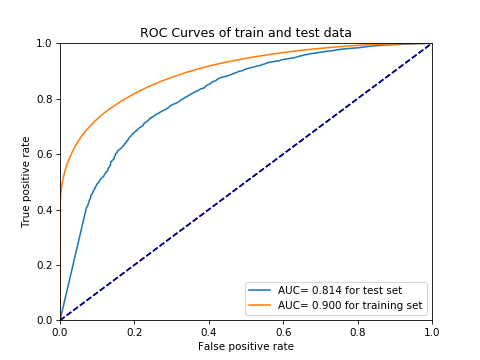

In [172]:
rocPlot(train_w2v,test_w2v,y_train,y_test)

### Confusion matrix plot training and test dataset

<IPython.core.display.Javascript object>


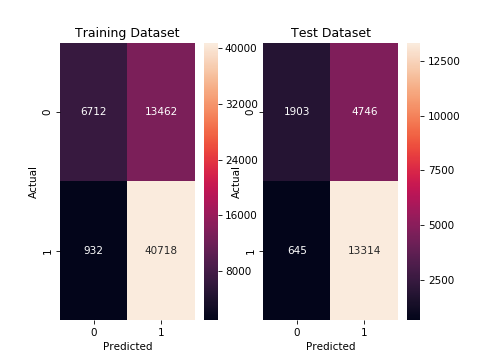

In [173]:
pred=clf.predict(test_w2v)
pred_train=clf.predict(train_w2v)
con_mx(pred_train, y_train,pred,y_test)

## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

### Hyperparameter tuning to find optimal depth and min samples split

<IPython.core.display.Javascript object>


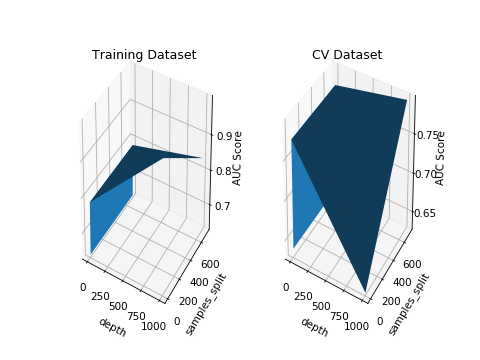

In [119]:
hypertuning(train_df,cv_df,y_train,y_cv)

### Hyperparameter tuning to find optimal depth and min samples split

In [182]:
clf=DecisionTreeClassifier(max_depth=70, min_samples_split=360, class_weight='balanced',random_state=42)
clf.fit(train_df,y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=70, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=360,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

### ROC plot for training and test dataset

<IPython.core.display.Javascript object>


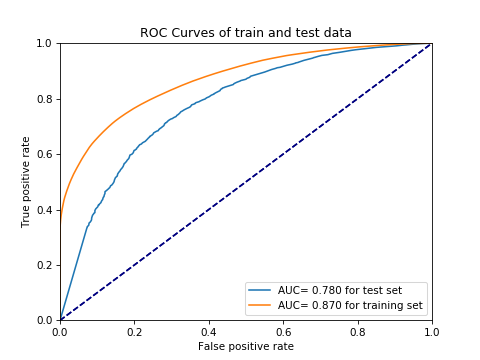

In [183]:
rocPlot(train_df,test_df,y_train,y_test)

### Confusion matrix plot training and test dataset

<IPython.core.display.Javascript object>


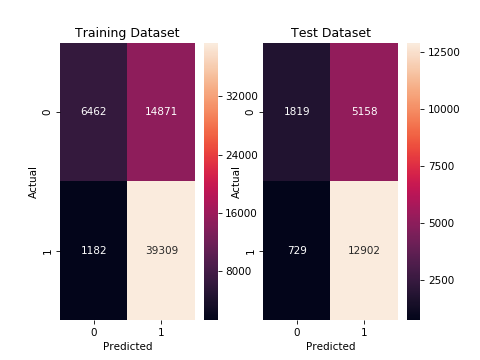

In [184]:
pred=clf.predict(test_df)
pred_train=clf.predict(train_df)
con_mx(pred_train, y_train,pred,y_test)

# [6] Conclusions

In [186]:
from prettytable import PrettyTable
x=PrettyTable()
x.field_names=["Vectorizer", "Depth", "Min_samples_split","AUC_training_Set" ,"AUC_test_set"]
x.add_row(["BOW", 80, 500,0.914, 0.817])
x.add_row(["TF-IDF",50, 520,0.915, 0.803])
x.add_row(["AVG W2V",90, 300,0.900 ,0.814])
x.add_row(["TFIDF W2V",70, 360,0.870, 0.780])
print(x)

+------------+-------+-------------------+------------------+--------------+
| Vectorizer | Depth | Min_samples_split | AUC_training_Set | AUC_test_set |
+------------+-------+-------------------+------------------+--------------+
|    BOW     |   80  |        500        |      0.914       |    0.817     |
|   TF-IDF   |   50  |        520        |      0.915       |    0.803     |
|  AVG W2V   |   90  |        300        |       0.9        |    0.814     |
| TFIDF W2V  |   70  |        360        |       0.87       |     0.78     |
+------------+-------+-------------------+------------------+--------------+


So, in this assignment, I have applied Decision tree model on all four vectorizers(BOW, TFIDF, W2V, TFIDF W2V). We can see that the AUC scores for all the vectorizers are not that good. First, DT is very prone to overfitting and so doesn't perform very well on high dimensional data. 

Since, DT follows greedy approach to select node, it doesn't end with optimal tree model. So, rather than classic DT, DT is mostly used as underlying model with bagging, boosting to overcome its problem.

Advantage of DT is, it's glass box model. It means it is highly interpretable and simple.
The class of a new input can be classified by following the tree all the way down to a leaf and by reporting the output of the leaf. 